Original Data Head:
  Neighborhood  SalePrice
0   North_Ames     215000
1   North_Ames     105000
2   North_Ames     172000
3   North_Ames     244000
4      Gilbert     189900

Number of unique neighborhoods: 28

DataFrame Head After LOOE:
  Neighborhood  SalePrice  Neighborhood_LOOE
0   North_Ames     215000      152712.664060
1   North_Ames     105000      136077.490969
2   North_Ames     172000      141070.451932
3   North_Ames     244000      153530.611479
4      Gilbert     189900      201574.436315

--- Example: 'CollgCr' ---
Original average SalePrice for CollgCr: $nan
Sample of LOOE encoded values for CollgCr:
Series([], Name: Neighborhood_LOOE, dtype: float64)
Note: The encoded values are slightly different from the original mean due to the 'leave-one-out' process and the added sigma.


C:\Users\basde\AppData\Local\Temp\ipykernel_14752\467012526.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_neighborhoods = df.groupby(feature_to_encode)[target].mean().sort_values().index


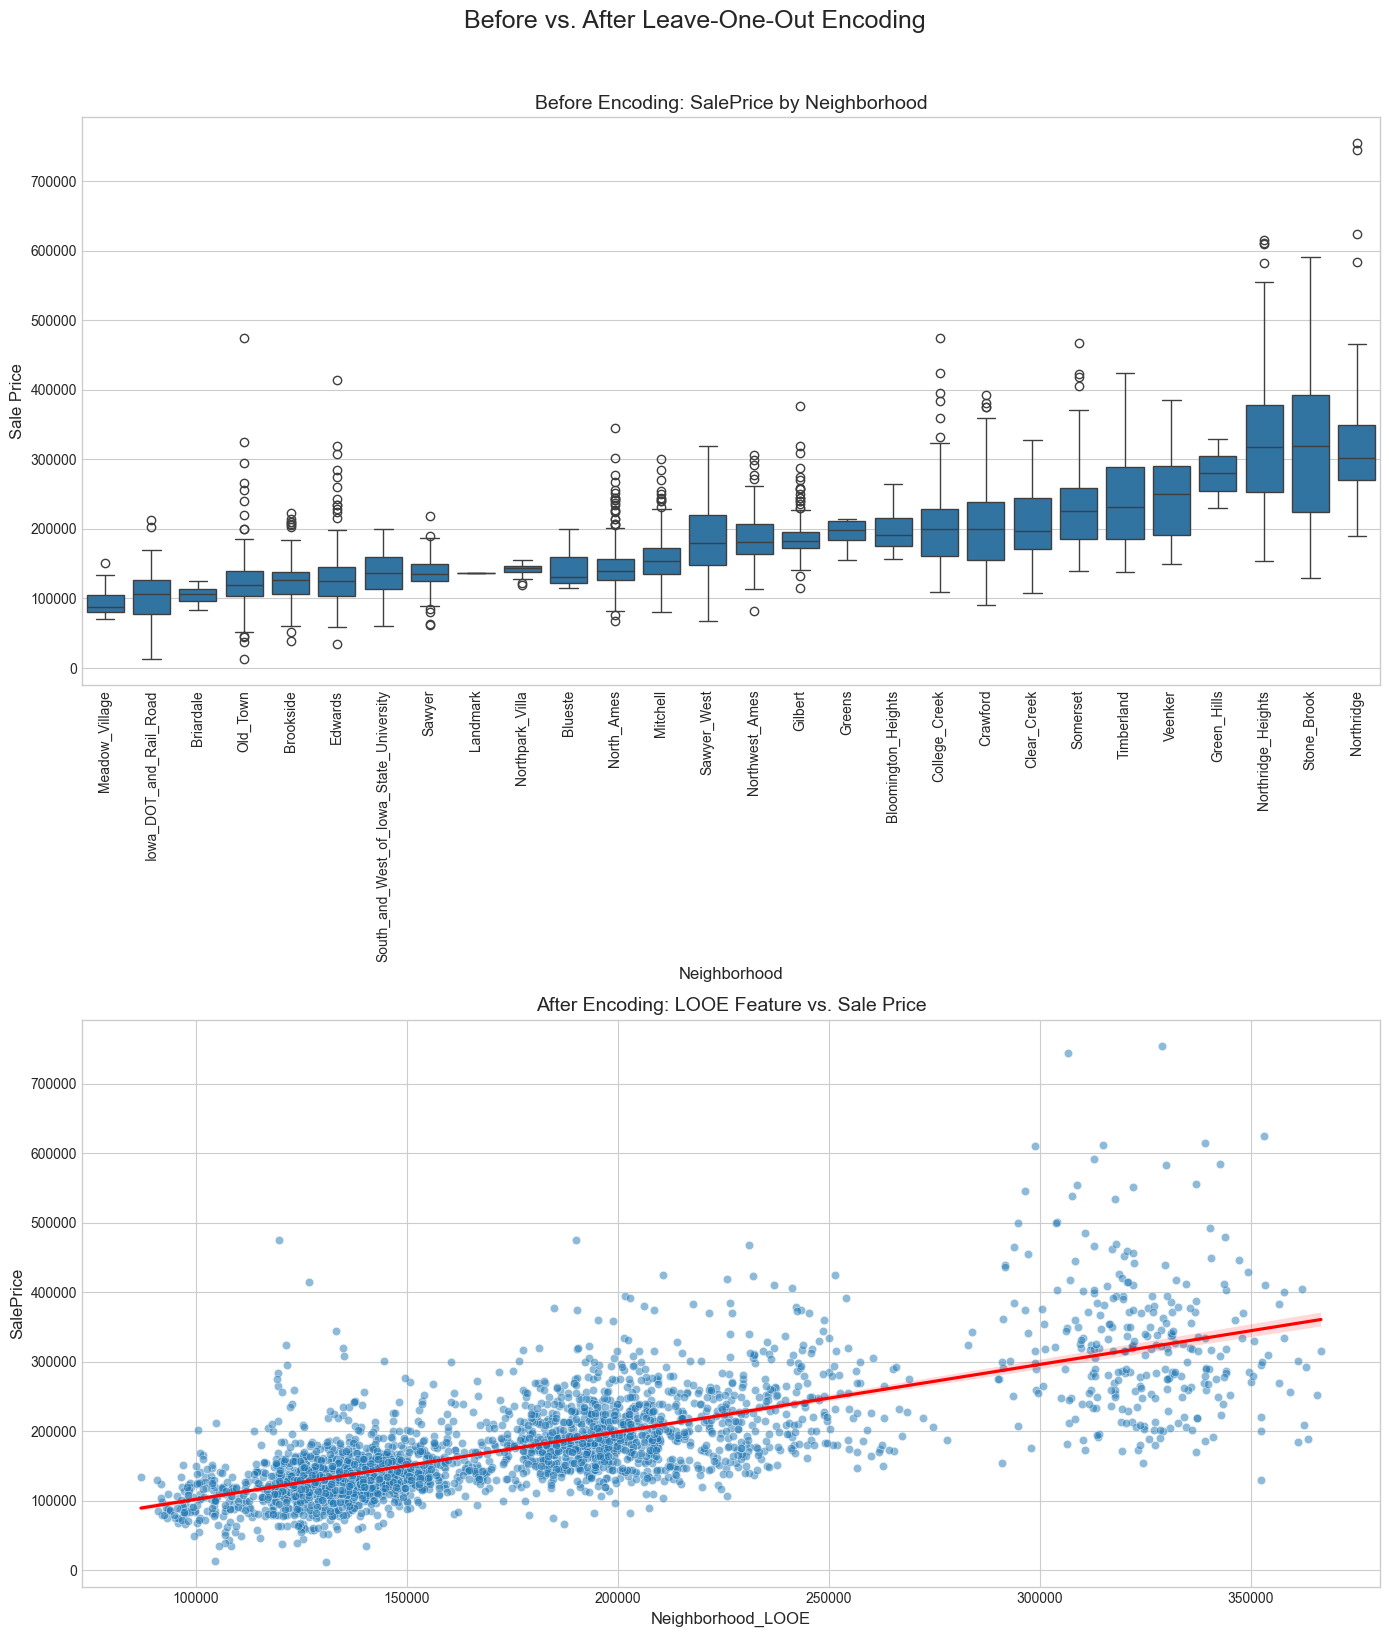


Final DataFrame Head:
  Neighborhood  SalePrice  Neighborhood_LOOE
0   North_Ames     215000      152712.664060
1   North_Ames     105000      136077.490969
2   North_Ames     172000      141070.451932
3   North_Ames     244000      153530.611479
4      Gilbert     189900      201574.436315


In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from category_encoders import LeaveOneOutEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- When to Use Leave-One-Out Encoding (LOOE) ---
# LOOE is a powerful technique for encoding categorical features, especially those with high cardinality 
# (many unique values). It's particularly useful in predictive modeling tasks.
#
# Key advantages:
# - It doesn't increase the dimensionality of the dataset, unlike one-hot encoding.
# - It can capture information about the relationship between the categorical feature and the target variable.
#
# Requirements:
# - It's a supervised encoding technique, meaning it requires a target variable (y) for the encoding process.
# - It's prone to target leakage if not used carefully, especially with small datasets. Using it within a
#   cross-validation loop is a best practice to mitigate this.

# --- 1. Load a Relevant Dataset ---
# We'll use the 'Ames Housing' dataset, which is great for this purpose as it has many
# categorical features and a clear numerical target ('SalePrice').
X, y = fetch_openml("Ames_Housing", version=1, return_X_y=True, as_frame=True, parser='auto')
df = pd.concat([X, y], axis=1)

# FIX: The target column from fetch_openml might not be named 'SalePrice'.
# This block programmatically finds the target column's name (from y.name)
# and renames it to 'SalePrice' for consistency, preventing the KeyError.
if y.name != 'SalePrice':
    df.rename(columns={y.name: 'SalePrice'}, inplace=True)

# For demonstration, let's simplify the dataset and handle missing values
df = df[['Neighborhood', 'SalePrice']].copy()
df.dropna(inplace=True)

# --- 2. Select a Feature to Work With ---
# We'll encode the 'Neighborhood' feature. This is a high-cardinality categorical
# feature, making it a good candidate for LOOE.
feature_to_encode = 'Neighborhood'
target = 'SalePrice'

print("Original Data Head:")
print(df.head())
print("\nNumber of unique neighborhoods:", df[feature_to_encode].nunique())

# --- 3. Apply Leave-One-Out Encoding (LOOE) ---
# The core idea of LOOE is to replace each category with the average of the target
# variable for all other instances of that category. For a given row, the value of its
# category is encoded as the mean of the target variable for all *other* rows that share the
# same category. This "leaving one out" prevents direct target leakage for that specific row.

# Initialize the LeaveOneOutEncoder
# The 'sigma' parameter adds a small amount of random noise to the encoding, which can
# help to reduce overfitting.
looe = LeaveOneOutEncoder(sigma=0.05)

# Create a new column for the encoded feature
encoded_col_name = f'{feature_to_encode}_LOOE'
df[encoded_col_name] = looe.fit_transform(df[feature_to_encode], df[target])


# --- 4. Show the Result ---
# We can see the new column with the LOOE values. Each value represents the
# average 'SalePrice' for the other houses in the same neighborhood.

print("\nDataFrame Head After LOOE:")
print(df.head())

# To better understand what happened, let's look at a specific neighborhood
neighborhood_example = 'CollgCr'
original_mean = df[df[feature_to_encode] == neighborhood_example][target].mean()
encoded_values = df[df[feature_to_encode] == neighborhood_example][encoded_col_name]

print(f"\n--- Example: '{neighborhood_example}' ---")
print(f"Original average SalePrice for {neighborhood_example}: ${original_mean:,.2f}")
print(f"Sample of LOOE encoded values for {neighborhood_example}:\n{encoded_values.head()}")
print("Note: The encoded values are slightly different from the original mean due to the 'leave-one-out' process and the added sigma.")


# --- 5. Before-and-After Visualization ---
# A great way to visualize the effect of this encoding is to compare the relationship
# between the original categorical feature and the target, and the new encoded
# numerical feature and the target.

# For better visualization, let's order the neighborhoods by their mean SalePrice
ordered_neighborhoods = df.groupby(feature_to_encode)[target].mean().sort_values().index

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 16))
fig.suptitle('Before vs. After Leave-One-Out Encoding', fontsize=18, y=1.02)

# Before: Boxplot of SalePrice for each Neighborhood
sns.boxplot(ax=axes[0], x=feature_to_encode, y=target, data=df, order=ordered_neighborhoods)
axes[0].set_title('Before Encoding: SalePrice by Neighborhood', fontsize=14)
axes[0].set_xlabel('Neighborhood', fontsize=12)
axes[0].set_ylabel('Sale Price', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# After: Scatter plot of the encoded feature vs. SalePrice
sns.scatterplot(ax=axes[1], x=encoded_col_name, y=target, data=df, alpha=0.5)
axes[1].set_title('After Encoding: LOOE Feature vs. Sale Price', fontsize=14)
axes[1].set_xlabel('Neighborhood (Leave-One-Out Encoded)', fontsize=12)
axes[1].set_ylabel('Sale Price', fontsize=12)

# Add a line of best fit to show the strong linear relationship created by the encoding
sns.regplot(ax=axes[1], x=encoded_col_name, y=target, data=df, scatter=False, color='red')


plt.tight_layout()
plt.show()

# --- Final DataFrame Head ---
print("\nFinal DataFrame Head:")
print(df.head())
